Importing required libraries

In [106]:
# For directory information
import os
from glob import glob

# Progress bars
from tqdm import tqdm

# Processing images
import cv2
import numpy as np

# Visualising images
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Model
from tensorflow.keras.models import load_model

Loading data

In [107]:
root_dir = r'/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
dirs = os.listdir(root_dir)

Splitting data into training and testing

In [108]:
# Taking 30 images per person as training data
X_train_paths = [img  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[:30]]
y_train = [dir  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[:30]]

In [109]:
# Taking 20 images per person as testing data
X_test_paths = [img  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[30:51]]
y_test = [dir  for dir in dirs for img in glob(os.path.join(root_dir, dir, '*'))[30:51]]

Image Preprocessing

In [110]:
# Default size
img_size = (160,160,3)

In [111]:
# Creating an array to store processed training images
X_train = np.empty(shape=(len(X_train_paths), img_size[0], img_size[1], img_size[2]))

for i, image_path in enumerate(X_train_paths):
    try:
      image = cv2.imread(image_path)
      if image is not None:
        resized_img = cv2.resize(image, (img_size[0],img_size[1])) 
        # Normalising images
        norm_img = resized_img.astype(np.float32) / 255.0 
        X_train[i] = norm_img
      else:
        print(f"{filename}: Error reading image (empty).")
    except (cv2.error, FileNotFoundError) as e:
      print(f"{filename}: Error verifying image - {e}")

In [112]:
# Creating an array to store processed testing images
X_test = np.empty(shape=(len(X_test_paths), img_size[0], img_size[1], img_size[2]))

for i, image_path in enumerate(X_test_paths):
    try:
      image = cv2.imread(image_path)
      if image is not None:
        resized_img = cv2.resize(image, (img_size[0],img_size[1]))
        norm_img = resized_img.astype(np.float32) / 255.0
        X_test[i] = norm_img
      else:
        print(f"{filename}: Error reading image (empty).")
    except (cv2.error, FileNotFoundError) as e:
      print(f"{filename}: Error verifying image - {e}")

Displaying images

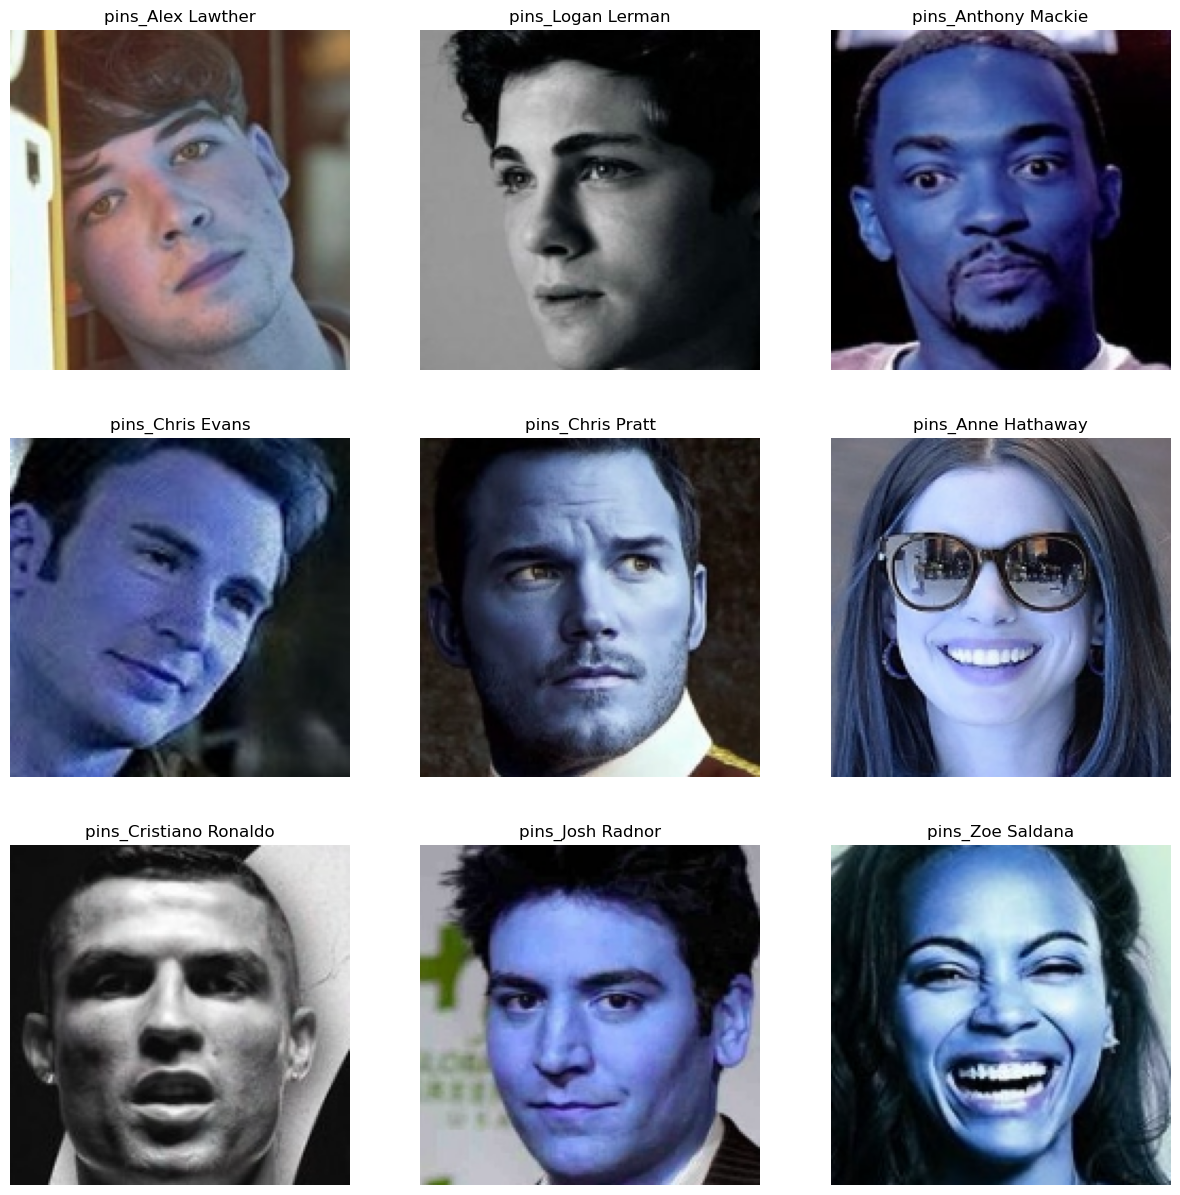

In [113]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[50*i])
    plt.title(y_train[50*i])  # Display the class label
    plt.axis('off')
plt.show()

Loading the model

In [114]:
# Using pretrained model
model = load_model('/kaggle/input/facenet-keras/facenet_keras.h5')

In [115]:
# model.summary()

In [116]:
# # If you are using custom image size run this cell
# from keras.models import Model
# from keras.layers import Input

# # Load your pretrained model
# model = ...
# # Create a new input layer with the desired input size
# new_input = Input(shape=(..., ..., 3))

# # Use the new input to build a new model
# new_output = model(new_input)
# new_model = Model(new_input, new_output)

In [117]:
# # Change the output layer according to the task
# output_layer = tf.keras.layers...  # Output layer
# model = tf.keras.Model(inputs=..., outputs=output_layer)

Generating embeddings from the model

In [118]:
embeddings = np.empty(shape=(len(X_train_paths), 128))
for i, image_path in tqdm(enumerate(X_train_paths)):
    # Model returns a feature embeddings vector of size (128)
    embeddings[i] = model.predict(X_train[i][np.newaxis])
    # Clears the output screen
    clear_output()
embeddings.shape

3150it [04:17, 12.23it/s]


(3150, 128)

Finding the average of embeddings of same person to produce more generalised results

In [119]:
#Store these embeddings in a database to compare new embeddings against them
# Averaging the 30 embeddings of each person
averaged_embeddings = embeddings.reshape(105, 30, 128).mean(axis=1)
averaged_embeddings.shape

(105, 128)

Predicting classes

In [120]:
def predict_class(img):
    img_emb = model.predict(img[np.newaxis])
    # Array to store the embedding distance b/w the target image and the database of images
    temp = np.empty(shape=(105))
    for i, emb in enumerate(averaged_embeddings):
        # Calculating embedding distance
        embedding_distance = emb-img_emb
        # L2 normalization
        embedding_distance_norm = np.linalg.norm(embedding_distance)
        temp[i] = embedding_distance_norm
    # Finding the image which is similar to the target
    label_index = temp.argmin()
    return dirs[label_index]

In [121]:
# Predicting labels for the testing images
y_pred = []
for img in tqdm(X_test):
    y_pred.append(predict_class(img))
    clear_output()

100%|██████████| 2205/2205 [03:03<00:00, 12.00it/s]


Displaying images with predicted labels

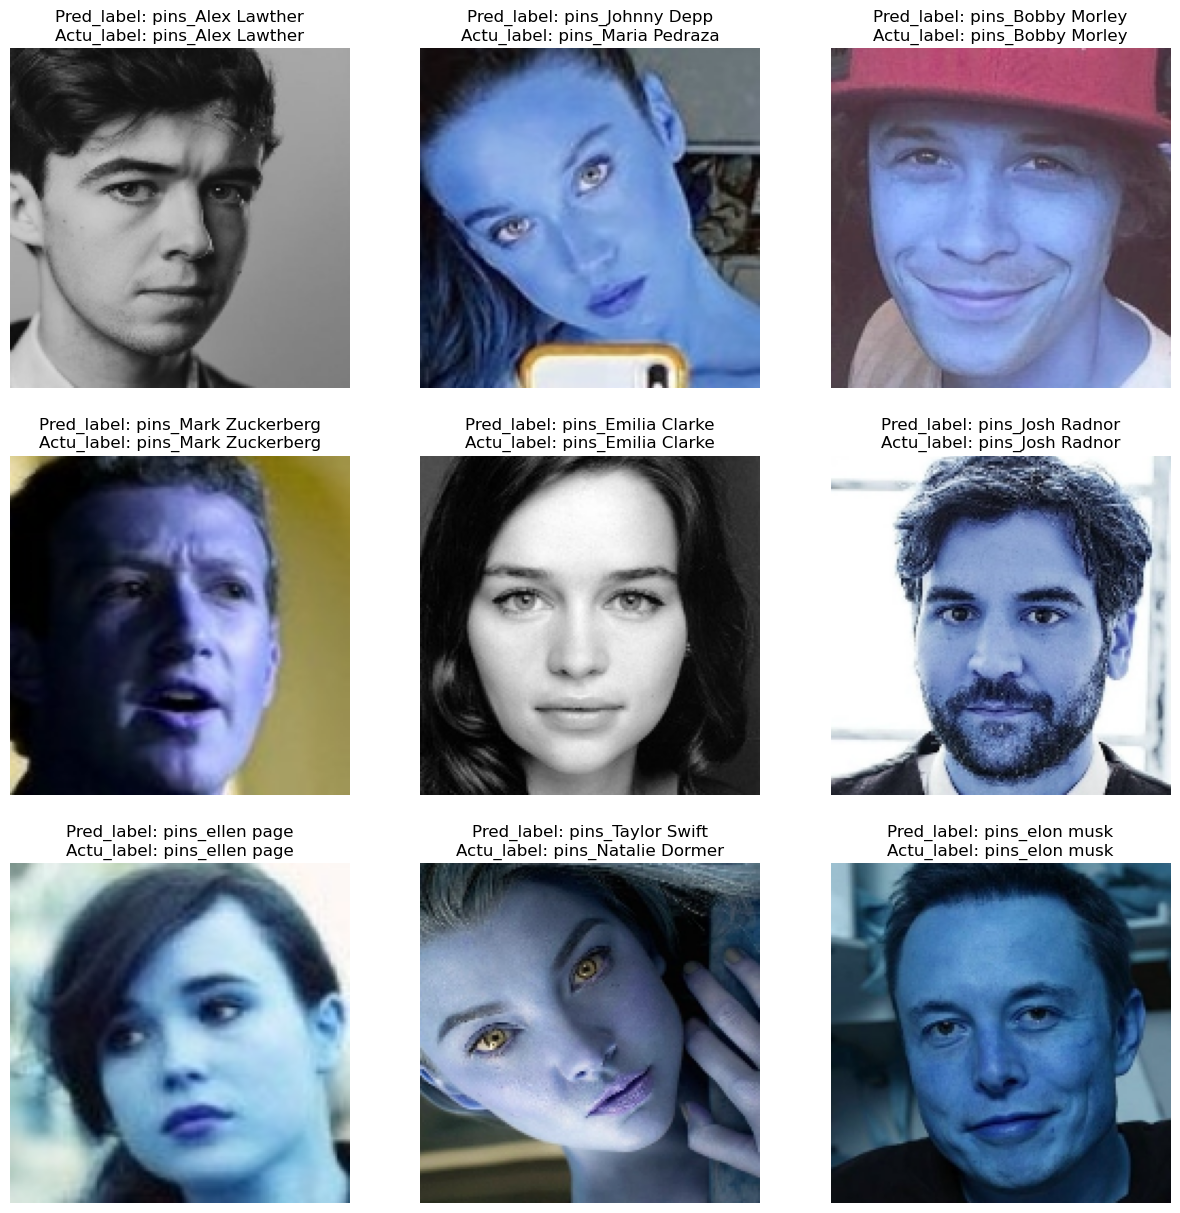

In [122]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[50*i])
    plt.title('Pred_label: '+y_pred[50*i]+'\nActu_label: '+y_test[50*i])  # Display the class label
    plt.axis('off')
plt.show()

Calculating Accuracy 

In [123]:
correct = 0

for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        correct = correct+1
print('Accuracy =',(correct/len(y_test))*100)

Accuracy = 88.16326530612245


Achieved 90%+ accuracy by just using the pretrained model. You can train the model using the complete dataset to increase the accuracy. Manually selecting the images for the database which best represents the images in various conditions make the model more efficient

There are different models like vgg-16, resnet, xception etc., for image classification. You can customize and use them according to your task.

In [ ]:
#Dataset used: pins-face-recognition
#Model used: facenet-keras